## 目錄
- Step 0. Loading dataset
- Step 1. Data preprocessing
    - Step 1.1 Creating Training and Testing sets
    - Step 1.2 Scaling data
    - Step 1.3 define sliding window function 
- Step 2. Build model
    - Step 2.1 Build Model
    - Step 2.2 Setting optimizer and make compile
    - Step 2.3 Training model
    - Step 2.4 model summary
- Step 3. Plotting predictions from the network
    - plot dataset
- Practice
    - 把Open、High、Low、Close跟Volume都當Feature

# import package

這份文件的資料集是Tesla從2014年到2017的股票歷史。

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#|%matplotlib inline|

## Step 0. Loading dataset

In [6]:
tesla_stocks = pd.read_csv('Data/tesla_stocks.csv')

In [9]:
# 資料共有六|個資訊，日期、開盤、當日最高、當日最低、收盤、成交量
tesla_stocks.head()
#tesla_stocks.shape

,Date,Open,High,Low,Close,Volume
0,4-Aug-14,234.38,240.50,233.27,238.52,5967406
1,5-Aug-14,237.47,242.99,235.69,238.49,5388581
2,6-Aug-14,238.90,251.42,238.58,248.93,9249265
3,7-Aug-14,250.12,256.69,249.12,252.39,7478926
4,8-Aug-14,251.16,251.76,246.50,248.13,5099061


## Step 1. Data preprocessing

In [10]:
# 簡化預測複雜度，我們只使用收盤價預測
data_to_use = tesla_stocks['Close'].values

In [11]:
# 資料共有756天成交紀錄
print('Total number of days in the dataset: {}'.format(len(data_to_use)))

Total number of days in the dataset: 756


### Step 1.1 Creating Training and Testing sets
分割資料時，必須要在進行標準化之前進行分割。因為標準化會基於所有資料點調整資料分佈，但我們希望測試資料不會受到訓練資料的任何影響。

#### Note: 在做資料處理之前先分割資料很重要，不要汙染測試集。

In [7]:
data_to_use = tesla_stocks['Close'].values

In [8]:
print('Total number of days in the dataset: {}'.format(len(data_to_use)))

Total number of days in the dataset: 756


### Step 1.2 Scaling data

In [9]:
# 使用sklearn套件將資料標準化(mean = 0, std = 1)
scaler = StandardScaler()

In [10]:
scaled_dataset = scaler.fit_transform(data_to_use.reshape(-1, 1))

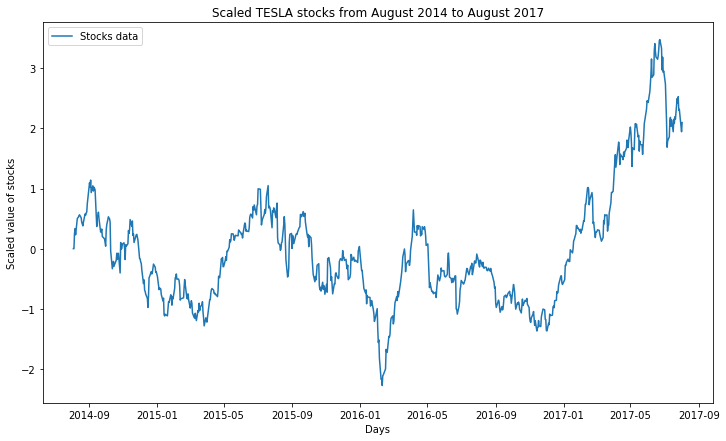

In [11]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

tesla_stocks.Date = pd.to_datetime(tesla_stocks.Date)
plt.figure(figsize=(12, 7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled TESLA stocks from August 2014 to August 2017')
plt.xlabel('Days')
plt.ylabel('Scaled value of stocks')
plt.plot(tesla_stocks.Date, scaled_dataset, label='Stocks data')
plt.legend()
plt.show()

### Step 1.3 define sliding window function 

In [12]:
# 抓取window_size的資料作為觀察資料(x), 下一天作為預測資料(y)

def window_data(data, window_size):
    X = []
    y = []
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        i += 1
    X = np.array(X)
    y = np.array(y)
    assert len(X) == len(y)
    return X, y

In [24]:
window_size = 7
X, y = window_data(scaled_dataset, window_size)

In [14]:
X_train = np.array(X[:700])
y_train = np.array(y[:700])

X_test = np.array(X[700:])
y_test = np.array(y[700:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (700, 7, 1)
y_train size: (700, 1)
X_test size: (49, 7, 1)
y_test size: (49, 1)


In [15]:
print(X_test.shape)
print(X_train.shape)

(49, 7, 1)
(700, 7, 1)


<img src='images/LSTM_stock_model(sequential).png'/>

## Step 2. Build model

In [16]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras.layers import TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam

### Step 2.1 Build Model

In [17]:
model = Sequential()
model.add(LSTM(units=16, activation='relu', return_sequences=True))
model.add(LSTM(units=16, activation='relu', return_sequences=False))
model.add(Flatten())
model.add(Dense(units=1))

### Step 2.2 Setting optimizer and make compile

In [18]:
opt = Adam(lr=0.001, decay=1e-6, clipvalue=5)

model.compile(loss='mse', optimizer=opt, metrics=['mse'])

### Step 2.3 Training model

In [19]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Train on 700 samples, validate on 49 samples
Epoch 1/100
700/700 [==============================] - 5s 7ms/sample - loss: 0.5499 - mse: 0.5499 - val_loss: 6.6267 - val_mse: 6.6267
Epoch 2/100
700/700 [==============================] - 0s 616us/sample - loss: 0.3990 - mse: 0.3990 - val_loss: 5.3652 - val_mse: 5.3652
Epoch 3/100
700/700 [==============================] - 0s 600us/sample - loss: 0.2216 - mse: 0.2216 - val_loss: 1.9594 - val_mse: 1.9594
Epoch 4/100
700/700 [==============================] - 0s 610us/sample - loss: 0.1060 - mse: 0.1060 - val_loss: 13.9846 - val_mse: 13.9846
Epoch 5/100
700/700 [==============================] - 0s 607us/sample - loss: 0.0690 - mse: 0.0690 - val_loss: 8.0429 - val_mse: 8.0429
Epoch 6/100
700/700 [==============================] - 0s 619us/sample - loss: 0.0642 - mse: 0.0642 - val_loss: 8.1495 - val_mse: 8.1495
Epoch 7/100
700/700 [==============================] - 0s 625us/sample - loss: 0.0610 - mse: 0.0610 - val_loss: 6.2119 - val_mse: 6.2

### Step 2.4 model summary

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  1152      
_________________________________________________________________
lstm_1 (LSTM)                multiple                  2112      
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  17        
Total params: 3,281
Trainable params: 3,281
Non-trainable params: 0
_________________________________________________________________


## Step 3. Plotting predictions from the network

In [21]:
# Training set預測結果
training_set_pred = np.array([])

training_set_pred = model.predict(X_train)

# Testing set預測結果

testing_set_pred = model.predict(X_test)

In [22]:
# 把資料放到list裡面準備畫圖
# 因為我們是用前七天預測第8天股價，故前七天設為None
training = [None]*window_size
for i in range(len(X_train)):
    training.append(training_set_pred[i])
testing = [None] * (window_size + len(X_train))
testing_loss = 0
for i in range(len(X_test)):
    testing.append(testing_set_pred[i])
    training.append(None)
    testing_loss += (testing_set_pred[i] - y_test[i])**2
print('testing_loss:', testing_loss / len(X_test))

testing_loss: [0.07021739]


### plot dataset

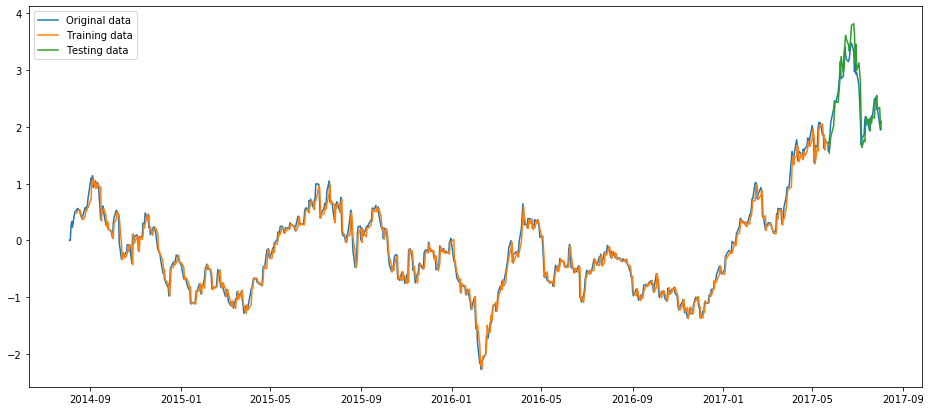

In [23]:
plt.figure(figsize=(16, 7))
plt.plot(tesla_stocks.Date, scaled_dataset, label='Original data')
plt.plot(tesla_stocks.Date, training, label='Training data')
plt.plot(tesla_stocks.Date, testing, label='Testing data')
plt.legend()
plt.show()

## Practice
1. 把Open、High、Low、Close跟Volume都當Feature